In [2]:
!pip install tqdm -U

     |████████████████████████████████| 72 kB 29 kB/s  eta 0:00:01


In [1]:
import numpy as np 
import _pickle as cPickle
import gzip
import os
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
# utility functions

def one_hot_encoded(y, num_class):
    n = y.shape[0]
    onehot = np.zeros((n, num_class), dtype="int32")
    for i in range(n):
        idx = y[i]
        onehot[i][idx] = 1
    return onehot


def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)  # both are not one hot encoded


def softmax(x):
    exp_x = np.exp(x - x.max(axis = 1, keepdims=True)) #фиксим неустойчивость экспоненты
    exp_x /= exp_x.sum(axis = 1, keepdims=True)
    return exp_x
    
# l2 regularization
def l2_reg(layers, lam=0.001):
    reg_loss = 0.0
    for layer in layers:
        if hasattr(layer, 'W'):
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)
    return reg_loss


# l2 regularization grad
def delta_l2_reg(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):
            grad[0] += lam * layer.W
    return grads


In [3]:
x = np.ones((3, 3))
x[:, 1] = np.arange(3)
x, softmax(x)

(array([[1., 0., 1.],
        [1., 1., 1.],
        [1., 2., 1.]]), array([[0.4223188 , 0.1553624 , 0.4223188 ],
        [0.33333333, 0.33333333, 0.33333333],
        [0.21194156, 0.57611688, 0.21194156]]))

In [4]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [5]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        return np.maximum(X, 0)
    
    def backward(self, dout, mode):
        self.gradInput = dout.copy()
        self.gradInput[self.X <= 0] = 0
        return self.gradInput, []

In [6]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = ReLU()
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 12))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [7]:
class Linear():

    def __init__(self, in_size, out_size):

        # Xavier init
        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size + out_size/ 2.)
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        return self.X.dot(self.W) + self.b
    
    def backward(self, dout, mode):
        self.gradW = self.X.T.dot(dout)
        self.gradB = np.mean(dout, axis = 0)
        self.gradInput = dout.dot(self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

In [8]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = Linear(12, 5)
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 5))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[-0.57149177 -0.30378623  0.51355251 -0.05843785  0.79858359  0.64475902
  -0.006915   -0.40036966 -0.0821716   0.3528353   0.73196141 -0.75795089]
 [-0.57149177 -0.30378623  0.51355251 -0.05843785  0.79858359  0.64475902
  -0.006915   -0.40036966 -0.0821716   0.3528353   0.73196141 -0.75795089]
 [-0.57149177 -0.30378623  0.51355251 -0.05843785  0.79858359  0.64475902
  -0.006915   -0.40036966 -0.0821716   0.3528353   0.73196141 -0.75795089]
 [-0.57149177 -0.30378623  0.51355251 -0.05843785  0.79858359  0.64475902
  -0.006915   -0.40036966 -0.0821716   0.3528353   0.73196141 -0.75795089]
 [-0.57149177 -0.30378623  0.51355251 -0.05843785  0.79858359  0.64475902
  -0.006915   -0.40036966 -0.0821716   0.3528353   0.73196141 -0.75795089]
 [-0.57149177 -0.30378623  0.51355251 -0.05843785  0.79858359  0.64475902
  -0.006915   -0.40036966 -0.0821716   0.3528353   0.73196141 -0.75795089]
 [-0.57149177 -0.30378623  0.51355251 -0.05843785  0.79858359  0.64475902
  -0.006915   -0.40036966 -0.082

In [9]:
class CrossEntropyLoss(object):

    def forward(self, X, y):
        self.n = y.shape[0]
        self.p = softmax(X)
        ce = - np.sum(np.log(self.p[np.arange(self.n), y])) / self.n
        return ce
    
    def backward(self, X, y):
        dx = self.p.copy()
        dx[np.arange(self.n), y] -= 1
        dx /= self.n
        return dx

In [10]:
ce = CrossEntropyLoss()
x = np.array([[0.75, 0.25], [0.99, 0.01]])
y = np.array([1, 0]).T
ce.forward(x, y)
ce.backward(x, y)

array([[ 0.31122967, -0.31122967],
       [-0.13644589,  0.13644589]])

## NN implementation

In [11]:
class NN:

    def __init__(self, loss_func=CrossEntropyLoss(), mode = 'train'):
    
        self.layers = []
        self.params = []
        self.loss_func = loss_func
        self.grads = []
        self.mode = mode

    def add_layer(self,layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X, self.mode)
        return X

    def backward(self, dout):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout, self.mode)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        dout = self.loss_func.backward(out,y)
        loss += l2_reg(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_reg(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)


    def dispGradParam():
        print(self.grads)
    

    def clear_grad_param(self):
        self.grads = []

In [12]:
# SGD with momentum
def update(velocity, params, grads, learning_rate=0.001, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]


# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    X, y = shuffle(X, y)

    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, ...]
        y_batch = y[i:i + minibatch_size, ...]

        minibatches.append((X_batch, y_batch))
    return minibatches


In [13]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9,
                 verbose=True, X_val=None, y_val=None, nesterov=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    c = 0 
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        if verbose:
            print("Epoch {0}".format(i + 1))

        # iterate over mini batches
        for X_mini, y_mini in tqdm(minibatches):

            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads,
                            learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in tqdm(minibatches_val):
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)


        # accuracy of model at end of epoch after all mini batch updates   

        if verbose:
            m_train = X_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")

            for i in range(0, m_train, minibatch_size):
                X_tr = X_train[i:i + minibatch_size, : ]
                y_tr = y_train[i:i + minibatch_size, ]
                y_train_pred = np.append(y_train_pred, net.predict(X_tr))

            for i in range(0, m_val, minibatch_size):
                X_va = X_val[i:i + minibatch_size, : ]
                y_va = y_val[i:i + minibatch_size, ]
                y_val_pred = np.append(y_val_pred, net.predict(X_va))

            train_acc = check_accuracy(y_train, y_train_pred)
            val_acc = check_accuracy(y_val, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))


            # early stopping with patience = 5 on val loss

            if len(val_loss_epoch) == 0:
                val_loss_epoch.append(mean_val_loss)
            else:
                for j in val_loss_epoch[-5:]:
                    if mean_val_loss > j:
                        c += 1
                    else:
                        c = 0
                if c > 5:
                    print('Early stopping')
                    return net
                else:
                    c = 0
                    val_loss_epoch.append(mean_val_loss)    


            print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(
                mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net


In [16]:

# Get preprocessed training and validation data

X_train = np.array([
    [1, 2, 1, 2],
    [2, 4, 2, 4],
    [2, 1, 2, 1],
    [4, 2, 4, 2],
])

y_train = np.array([0, 1, 0, 1])
X_val = X_train.copy()
y_val = y_train.copy()

print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

model.add_layer(Linear(4, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 2))
# model.add_layer(CrossEntropyLoss())
# add some layers
# YOUR CODE HERE

model = train(model, X_train , y_train, minibatch_size=4, epoch=100,
           learning_rate=0.1, X_val=X_val, y_val=y_val)




  0%|          | 0/1 [00:00<?, ?it/s]

(4, 4)
(4, 4)
Epoch 1
Loss = 0.861972406955323 | Training Accuracy = 0.5 | Val Loss = 0.6851584228688161 | Val Accuracy = 0.5
Epoch 2
Loss = 0.6851584228688161 | Training Accuracy = 0.5 | Val Loss = 0.6813526747116484 | Val Accuracy = 0.5
Epoch 3
Loss = 0.6813526747116484 | Training Accuracy = 0.5 | Val Loss = 0.6791504797868688 | Val Accuracy = 0.5
Epoch 4
Loss = 0.6791504797868688 | Training Accuracy = 0.5 | Val Loss = 0.6770894170266254 | Val Accuracy = 0.5
Epoch 5
Loss = 0.6770894170266254 | Training Accuracy = 0.5 | Val Loss = 0.6751259453096258 | Val Accuracy = 0.5
Epoch 6
Loss = 0.6751259453096258 | Training Accuracy = 0.5 | Val Loss = 0.6732226767352216 | Val Accuracy = 0.5
Epoch 7
Loss = 0.6732226767352216 | Training Accuracy = 0.5 | Val Loss = 0.6713744932470034 | Val Accuracy = 0.5
Epoch 8
Loss = 0.6713744932470034 | Training Accuracy = 0.5 | Val Loss = 0.6695612814562377 | Val Accuracy = 0.5
Epoch 9
Loss = 0.6695612814562377 | Training Accuracy = 0.5 | Val Loss = 0.66777415

  0%|          | 0/1 [00:00<?, ?it/s]

Loss = 0.6402285309308131 | Training Accuracy = 0.5 | Val Loss = 0.6385108378418449 | Val Accuracy = 0.5
Epoch 27
Loss = 0.6385108378418449 | Training Accuracy = 0.5 | Val Loss = 0.636790068753846 | Val Accuracy = 0.5
Epoch 28
Loss = 0.636790068753846 | Training Accuracy = 0.5 | Val Loss = 0.6350658503861387 | Val Accuracy = 0.5
Epoch 29
Loss = 0.6350658503861387 | Training Accuracy = 0.5 | Val Loss = 0.6333378227377764 | Val Accuracy = 0.5
Epoch 30
Loss = 0.6333378227377764 | Training Accuracy = 0.5 | Val Loss = 0.6316050219278943 | Val Accuracy = 0.5
Epoch 31
Loss = 0.6316050219278943 | Training Accuracy = 0.5 | Val Loss = 0.6298406330804069 | Val Accuracy = 0.5
Epoch 32
Loss = 0.6298406330804069 | Training Accuracy = 0.5 | Val Loss = 0.6280859157611253 | Val Accuracy = 0.5
Epoch 33
Loss = 0.6280859157611253 | Training Accuracy = 0.5 | Val Loss = 0.6263302856982255 | Val Accuracy = 0.5
Epoch 34
Loss = 0.6263302856982255 | Training Accuracy = 0.5 | Val Loss = 0.6245694634144902 | Val 

100%|██████████| 1/1 [00:00<00:00, 582.87it/s]

Loss = 0.5935351359909549 | Training Accuracy = 0.5 | Val Loss = 0.591619960115599 | Val Accuracy = 0.5
Epoch 53
Loss = 0.591619960115599 | Training Accuracy = 0.5 | Val Loss = 0.5896691437456054 | Val Accuracy = 0.5
Epoch 54
Loss = 0.5896691437456054 | Training Accuracy = 0.5 | Val Loss = 0.5877269479513193 | Val Accuracy = 0.5
Epoch 55
Loss = 0.5877269479513193 | Training Accuracy = 0.5 | Val Loss = 0.5857732636520206 | Val Accuracy = 0.5
Epoch 56
Loss = 0.5857732636520206 | Training Accuracy = 0.5 | Val Loss = 0.5838068081570159 | Val Accuracy = 0.5
Epoch 57
Loss = 0.5838068081570159 | Training Accuracy = 0.5 | Val Loss = 0.5818271844568323 | Val Accuracy = 0.5
Epoch 58
Loss = 0.5818271844568323 | Training Accuracy = 0.5 | Val Loss = 0.5798340274152846 | Val Accuracy = 0.5
Epoch 59
Loss = 0.5798340274152846 | Training Accuracy = 0.5 | Val Loss = 0.5778282427919779 | Val Accuracy = 0.5
Epoch 60
Loss = 0.5778282427919779 | Training Accuracy = 0.5 | Val Loss = 0.5758104704534556 | Val 


100%|██████████| 1/1 [00:00<00:00, 597.22it/s]


Loss = 0.5435302181231457 | Training Accuracy = 0.5 | Val Loss = 0.5412292860422421 | Val Accuracy = 0.5
Epoch 77
Loss = 0.5412292860422421 | Training Accuracy = 0.5 | Val Loss = 0.5389077100235458 | Val Accuracy = 0.5
Epoch 78
Loss = 0.5389077100235458 | Training Accuracy = 0.5 | Val Loss = 0.5365649893945783 | Val Accuracy = 0.5
Epoch 79
Loss = 0.5365649893945783 | Training Accuracy = 0.5 | Val Loss = 0.5342006987257282 | Val Accuracy = 0.5
Epoch 80
Loss = 0.5342006987257282 | Training Accuracy = 0.5 | Val Loss = 0.5318144435673765 | Val Accuracy = 0.5
Epoch 81
Loss = 0.5318144435673765 | Training Accuracy = 0.5 | Val Loss = 0.5294058302053819 | Val Accuracy = 0.5
Epoch 82
Loss = 0.5294058302053819 | Training Accuracy = 1.0 | Val Loss = 0.5269744716281756 | Val Accuracy = 1.0
Epoch 83
Loss = 0.5269744716281756 | Training Accuracy = 1.0 | Val Loss = 0.5245199812926895 | Val Accuracy = 1.0
Epoch 84
Loss = 0.5245199812926895 | Training Accuracy = 1.0 | Val Loss = 0.5220419770940158 | Va

## Mnist training

In [17]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [18]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [19]:
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)


In [20]:
import matplotlib.pyplot as plt
%matplotlib notebook

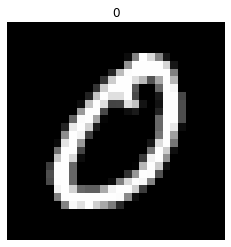

In [23]:
# visualize data

def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

vis_idx = 57
vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])

In [27]:
y_val.max()

9

In [91]:
print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

model.add_layer(Linear(784, 200))
model.add_layer(ReLU())
model.add_layer(Linear(200, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 10))

(52500, 784)
(17500, 784)


In [92]:
model = train(model, X_train , y_train, minibatch_size=128, epoch=25,
           learning_rate=0.001, X_val=X_val, y_val=y_val)

  3%|▎         | 11/411 [00:00<00:03, 108.99it/s]

Epoch 1


  1%|          | 5/411 [00:00<00:10, 37.34it/s]

Loss = 1.2529499048429034 | Training Accuracy = 0.9119047619047619 | Val Loss = 0.33486900813232284 | Val Accuracy = 0.9048571428571428
Epoch 2


  2%|▏         | 8/411 [00:00<00:07, 50.86it/s]

Loss = 0.38471607497795407 | Training Accuracy = 0.9375428571428571 | Val Loss = 0.21379794952508369 | Val Accuracy = 0.9270285714285714
Epoch 3


  1%|          | 4/411 [00:00<00:10, 37.06it/s]

Loss = 0.3218208808650636 | Training Accuracy = 0.9557142857142857 | Val Loss = 0.18319190430530724 | Val Accuracy = 0.9428
Epoch 4


  0%|          | 2/411 [00:00<00:21, 19.33it/s]

Loss = 0.2883530501652323 | Training Accuracy = 0.9621904761904762 | Val Loss = 0.17376999541934407 | Val Accuracy = 0.9476
Epoch 5


  1%|          | 3/411 [00:00<00:15, 25.67it/s]

Loss = 0.2659920770820246 | Training Accuracy = 0.9669142857142857 | Val Loss = 0.16862663441592105 | Val Accuracy = 0.9507428571428571
Epoch 6


  0%|          | 2/411 [00:00<00:21, 18.84it/s]

Loss = 0.24814440129913334 | Training Accuracy = 0.9704761904761905 | Val Loss = 0.16379874963259897 | Val Accuracy = 0.9525714285714286
Epoch 7


  1%|          | 3/411 [00:00<00:21, 19.24it/s]

Loss = 0.23391864102954305 | Training Accuracy = 0.9734095238095238 | Val Loss = 0.1638611419635391 | Val Accuracy = 0.9556
Epoch 8


  2%|▏         | 10/411 [00:00<00:04, 97.91it/s]

Loss = 0.22252095721629858 | Training Accuracy = 0.9749142857142857 | Val Loss = 0.16084185403067894 | Val Accuracy = 0.9559428571428571
Epoch 9


  2%|▏         | 9/411 [00:00<00:04, 89.23it/s]

Loss = 0.2119703833536249 | Training Accuracy = 0.9762666666666666 | Val Loss = 0.1591696175175984 | Val Accuracy = 0.9569142857142857
Epoch 10


  2%|▏         | 10/411 [00:00<00:04, 97.81it/s]

Loss = 0.2022428492638919 | Training Accuracy = 0.9784 | Val Loss = 0.153988189527163 | Val Accuracy = 0.9572
Epoch 11


  2%|▏         | 9/411 [00:00<00:04, 87.42it/s]

Loss = 0.19363045617969715 | Training Accuracy = 0.9795047619047619 | Val Loss = 0.14985177679639386 | Val Accuracy = 0.9570285714285715
Epoch 12


  0%|          | 2/411 [00:00<00:21, 18.91it/s]

Loss = 0.18616874875370876 | Training Accuracy = 0.9801333333333333 | Val Loss = 0.1433311280972805 | Val Accuracy = 0.958
Epoch 13


  1%|          | 3/411 [00:00<00:18, 22.51it/s]

Loss = 0.1796549122037346 | Training Accuracy = 0.9809714285714286 | Val Loss = 0.1377638530685665 | Val Accuracy = 0.9574857142857143
Epoch 14


  1%|          | 4/411 [00:00<00:11, 35.80it/s]

Loss = 0.17421439567919683 | Training Accuracy = 0.9827809523809524 | Val Loss = 0.13595316385729078 | Val Accuracy = 0.9575428571428571
Epoch 15


  0%|          | 2/411 [00:00<00:21, 19.32it/s]

Loss = 0.1683261689812088 | Training Accuracy = 0.9829523809523809 | Val Loss = 0.13293399159993202 | Val Accuracy = 0.9570285714285715
Epoch 16


  1%|          | 3/411 [00:00<00:15, 26.42it/s]

Loss = 0.16415834967884158 | Training Accuracy = 0.9825904761904762 | Val Loss = 0.13527711277172347 | Val Accuracy = 0.9573714285714285
Epoch 17


  0%|          | 2/411 [00:00<00:21, 19.17it/s]

Loss = 0.15912474349315564 | Training Accuracy = 0.984 | Val Loss = 0.13355238958309687 | Val Accuracy = 0.9581714285714286
Epoch 18


  2%|▏         | 9/411 [00:00<00:04, 84.10it/s]

Loss = 0.15553558633982204 | Training Accuracy = 0.9848 | Val Loss = 0.13491016676180703 | Val Accuracy = 0.9578857142857143
Epoch 19


  2%|▏         | 9/411 [00:00<00:04, 87.55it/s]

Loss = 0.15181354223531127 | Training Accuracy = 0.9882095238095238 | Val Loss = 0.13158451665880988 | Val Accuracy = 0.9608571428571429
Epoch 20


  2%|▏         | 9/411 [00:00<00:04, 82.30it/s]

Loss = 0.14820329451311767 | Training Accuracy = 0.9870666666666666 | Val Loss = 0.13035920586397987 | Val Accuracy = 0.9603428571428572
Epoch 21


  1%|          | 3/411 [00:00<00:15, 25.67it/s]

Loss = 0.1441052707296408 | Training Accuracy = 0.9897333333333334 | Val Loss = 0.12622515796537695 | Val Accuracy = 0.9614857142857143
Epoch 22


  1%|          | 5/411 [00:00<00:08, 45.50it/s]

Loss = 0.14117853813209716 | Training Accuracy = 0.9915619047619048 | Val Loss = 0.12455533409886299 | Val Accuracy = 0.9632571428571428
Epoch 23


  1%|          | 4/411 [00:00<00:10, 37.86it/s]

Loss = 0.1390297565702088 | Training Accuracy = 0.9937904761904762 | Val Loss = 0.12523105540110524 | Val Accuracy = 0.9635428571428571
Epoch 24


  1%|          | 3/411 [00:00<00:16, 25.24it/s]

Loss = 0.13731448486104064 | Training Accuracy = 0.9935238095238095 | Val Loss = 0.12476923221775105 | Val Accuracy = 0.9642285714285714
Epoch 25


100%|██████████| 137/137 [00:00<00:00, 219.14it/s]


Loss = 0.13578074426497622 | Training Accuracy = 0.9937333333333334 | Val Loss = 0.12654078050126968 | Val Accuracy = 0.9629142857142857


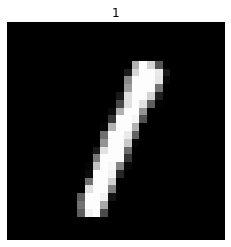

In [103]:
# visualize prediction 

vis_idx = 10
pred = model.predict(X_val[vis_idx])
vis(X_val[vis_idx].reshape(-1, 28), pred[0])

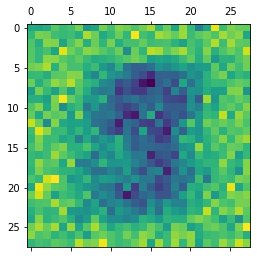

In [108]:
t = model.layers[0].W.mean(axis = 1).reshape(28, 28)
plt.matshow(t)

# TODO:
1) Add computational graph instead of list, model saving/loading, more optimizers, shedulers loss functions, operations, gpu support, utility tools ...

... Or simply use Pytorch/TF/whatever